# Importing necessary libraries

In [17]:
# Import required libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import praw
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_split

# Download required NLTK data
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Aveen\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Loading the Data

In [49]:
data_path = "../data/u.data"
genre_path = "../data/u.genre"
item_path = "../data/u.item"

# Load the u.data file
columns_data = ['UserID', 'MovieID', 'Rating', 'Timestamp']
data = pd.read_csv(data_path, sep="\t", names=columns_data, encoding="latin-1")

# Load the u.genre file
genre = pd.read_csv(genre_path, sep="|", header= None, names=["Genre", "GenreID"], encoding= "latin-1")

# Load the u.item file
columns_item = ['MovieID', 'Title', 'ReleaseDate', 'VideoReleaseDate', 'IMDBUrl'] + [f"Genre_{i}" for i in range(19)]
items = pd.read_csv(item_path, sep='|', names=columns_item, encoding="latin-1")

# Data Preprocessing

In [53]:
# Format the date column
items['RelaeaseDate'] = pd.to_datetime(items['ReleaseDate'], errors='coerce')

In [54]:
# Map Genres

genre_dict = dict(zip(genre['GenreID'], genre['Genre']))
genre_columns = [col for col in items.columns if 'Genre_' in col]

# Assign genres to movies:
def map_genres(row):
    return[genre_dict[idx] for idx, val in enumerate(row) if val == 1]

items['Genres'] = items[genre_columns].apply(map_genres, axis=1)

In [55]:
# Drop redundant columns
items = items[['MovieID', 'Title', 'ReleaseDate', 'Genres']]

## Data statistics

In [65]:
data.shape

(100000, 4)

In [71]:
data.info

<bound method DataFrame.info of        UserID  MovieID  Rating  Timestamp
0         196      242       3  881250949
1         186      302       3  891717742
2          22      377       1  878887116
3         244       51       2  880606923
4         166      346       1  886397596
...       ...      ...     ...        ...
99995     880      476       3  880175444
99996     716      204       5  879795543
99997     276     1090       1  874795795
99998      13      225       2  882399156
99999      12      203       3  879959583

[100000 rows x 4 columns]>

In [72]:
data.head()

,UserID,MovieID,Rating,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Genre statistics

In [66]:
genre.shape

(19, 2)

In [73]:
genre.info

<bound method DataFrame.info of           Genre  GenreID
0       unknown        0
1        Action        1
2     Adventure        2
3     Animation        3
4    Children's        4
5        Comedy        5
6         Crime        6
7   Documentary        7
8         Drama        8
9       Fantasy        9
10    Film-Noir       10
11       Horror       11
12      Musical       12
13      Mystery       13
14      Romance       14
15       Sci-Fi       15
16     Thriller       16
17          War       17
18      Western       18>

In [74]:
genre.head()

,Genre,GenreID
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


## Item Statistics

In [67]:
items.shape

(1682, 4)

In [75]:
items.info

<bound method DataFrame.info of       MovieID                                      Title  ReleaseDate  \
0           1                           Toy Story (1995)  01-Jan-1995   
1           2                           GoldenEye (1995)  01-Jan-1995   
2           3                          Four Rooms (1995)  01-Jan-1995   
3           4                          Get Shorty (1995)  01-Jan-1995   
4           5                             Copycat (1995)  01-Jan-1995   
...       ...                                        ...          ...   
1677     1678                          Mat' i syn (1997)  06-Feb-1998   
1678     1679                           B. Monkey (1998)  06-Feb-1998   
1679     1680                       Sliding Doors (1998)  01-Jan-1998   
1680     1681                        You So Crazy (1994)  01-Jan-1994   
1681     1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996   

                               Genres  
0     [Animation, Children's, Comedy]  
1       [Ac

In [76]:
items.head()

,MovieID,Title,ReleaseDate,Genres
0,1,Toy Story (1995),01-Jan-1995,"[Animation, Children's, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,[Thriller]
3,4,Get Shorty (1995),01-Jan-1995,"[Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,"[Crime, Drama, Thriller]"


# Merge Dataframes

In [57]:
# Merge the data with items
merged_data = pd.merge(data, items, on='MovieID')

# Exploratory Data Analysis (EDA)

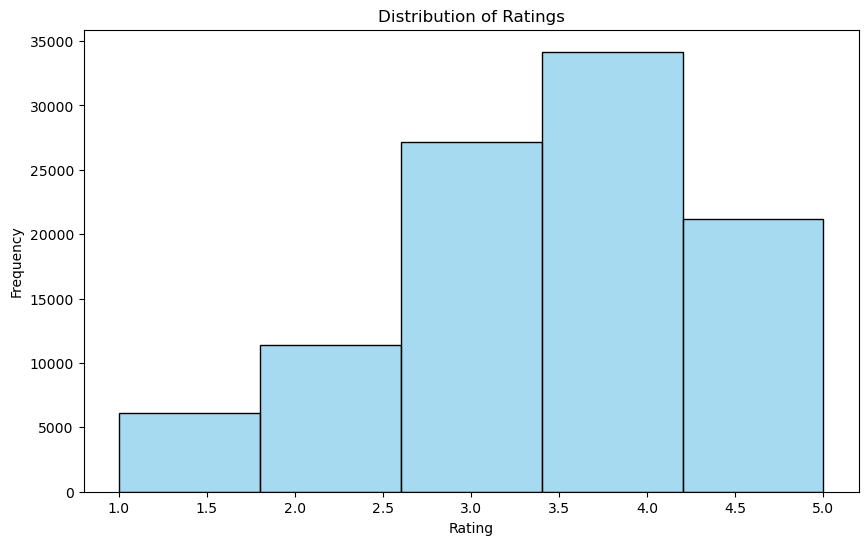

In [58]:
# Ratings Distribution

plt.figure(figsize=(10,6))
sns.histplot(merged_data['Rating'], bins=5, kde = False, color='skyblue')
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

C:\Users\Aveen\AppData\Local\Temp\ipykernel_9824\2433603612.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = most_rated.values, y= most_rated.index, palette='viridis')


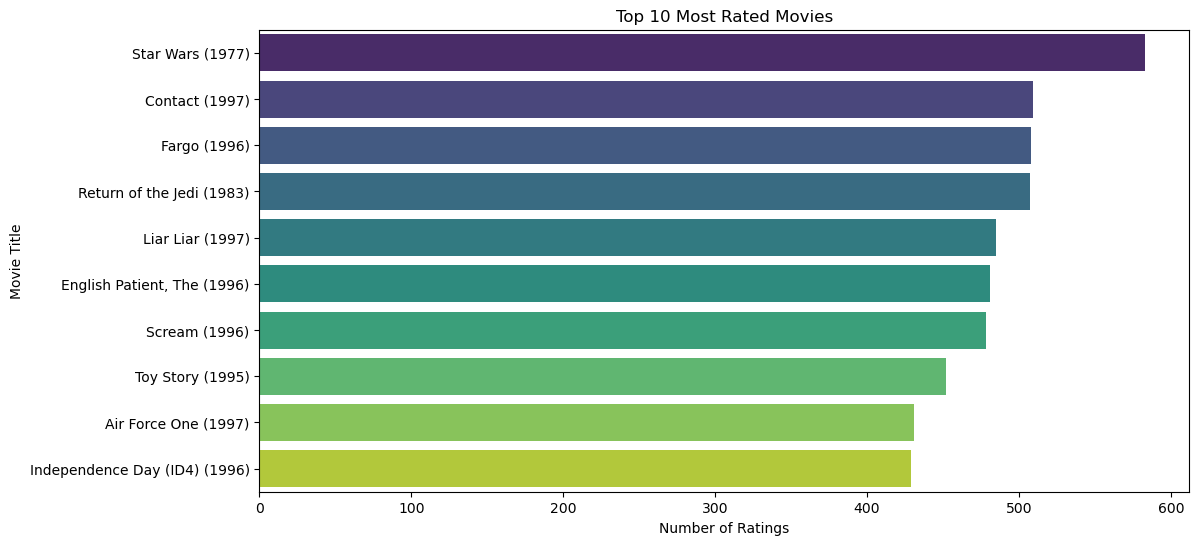

In [59]:
# Most Rated Movies

most_rated = merged_data['Title'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x = most_rated.values, y= most_rated.index, palette='viridis')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()


C:\Users\Aveen\AppData\Local\Temp\ipykernel_9824\2175662388.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = genre_ratings.values, y = genre_ratings.index, palette='coolwarm')


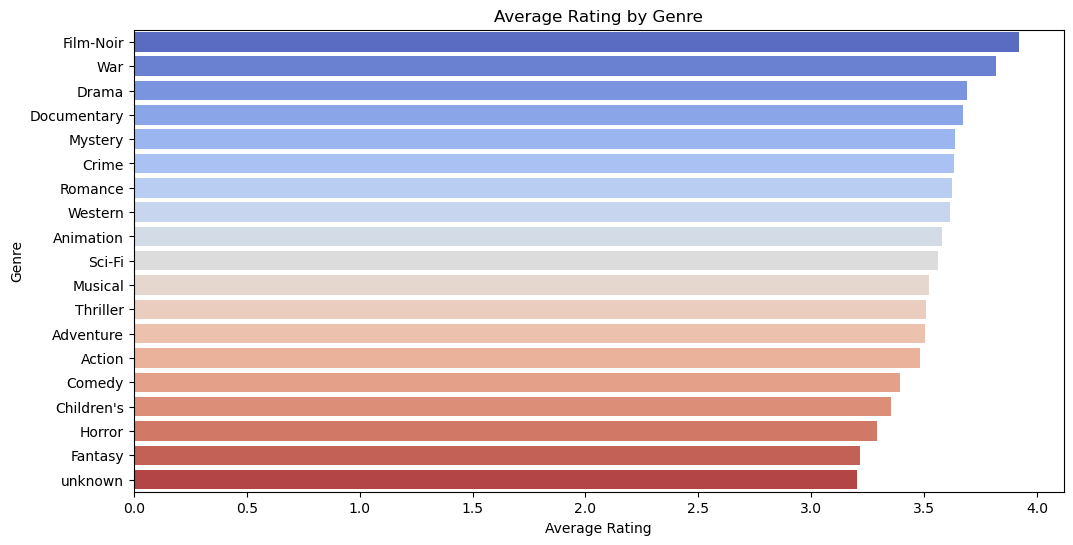

In [60]:
# Average Rating by Genre

genre_ratings = (
    merged_data.explode("Genres")
    .groupby('Genres')['Rating']
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize= (12,6))
sns.barplot(x = genre_ratings.values, y = genre_ratings.index, palette='coolwarm')
plt.title("Average Rating by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()

# Analaysis

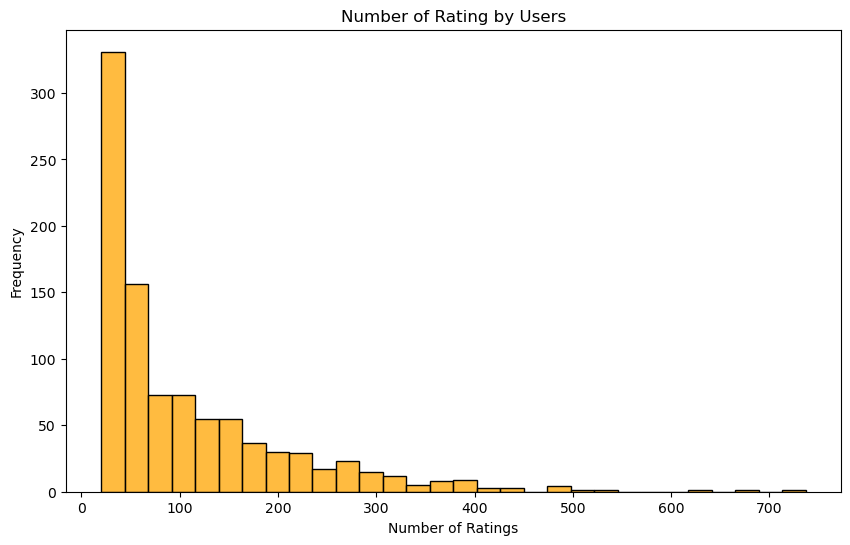

In [61]:
# User Rating Patterns

user_rating_count = merged_data.groupby('UserID')['Rating'].count()
plt.figure(figsize= (10,6))
sns.histplot(user_rating_count, kde = False, bins = 30, color = 'orange')
plt.title("Number of Rating by Users")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

Average Ratings by Genre:
Genres
Film-Noir      3.921523
War            3.815812
Drama          3.687379
Documentary    3.672823
Mystery        3.638132
Crime          3.632278
Romance        3.621705
Western        3.613269
Animation      3.576699
Sci-Fi         3.560723
Musical        3.521397
Thriller       3.509007
Adventure      3.503527
Action         3.480245
Comedy         3.394073
Children's     3.353244
Horror         3.290389
Fantasy        3.215237
unknown        3.200000
Name: Rating, dtype: float64


C:\Users\Aveen\AppData\Local\Temp\ipykernel_9824\892538839.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_rating_mean.values, y=genre_rating_mean.index, palette='coolwarm')


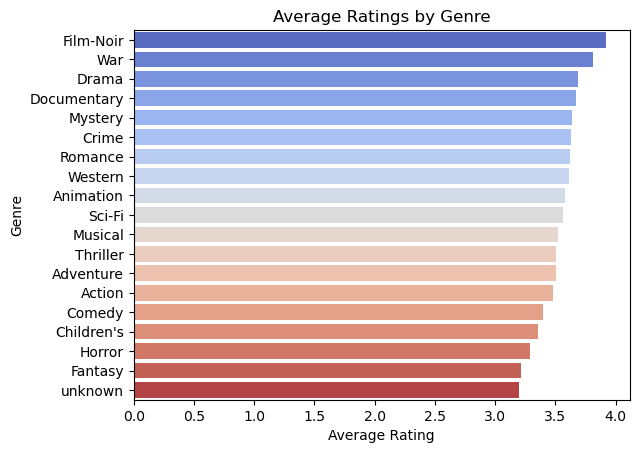

In [62]:
# Calculate the average rating per genre
genre_rating_mean = (
    merged_data.explode('Genres')
    .groupby('Genres')['Rating']
    .mean()
    .sort_values(ascending=False)
)

# Display the result
print("Average Ratings by Genre:")
print(genre_rating_mean)

# Visualize the average ratings
sns.barplot(x=genre_rating_mean.values, y=genre_rating_mean.index, palette='coolwarm')
plt.title("Average Ratings by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


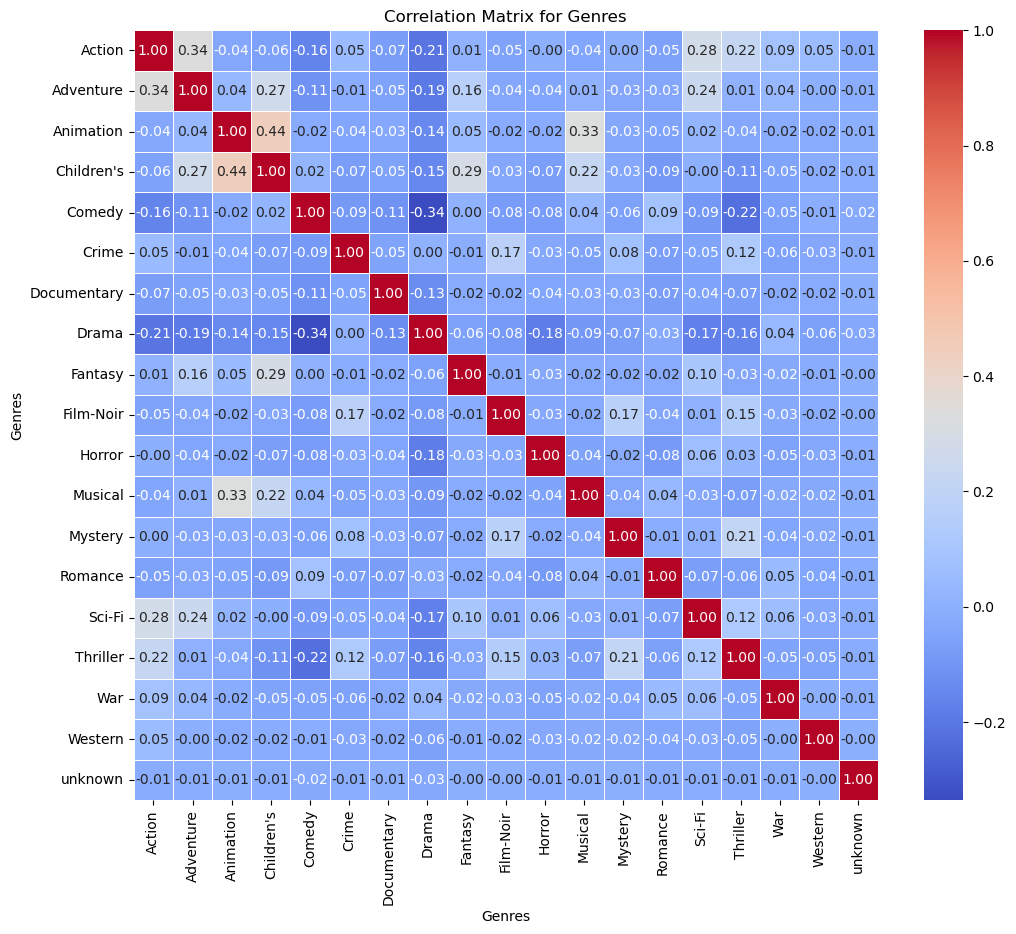

In [63]:
# Explode genres into binary columns
genre_matrix = merged_data.explode('Genres').assign(value=1)
genre_matrix = (
    genre_matrix.pivot_table(index='Title', columns='Genres', values='value', fill_value=0)
)

# Compute the correlation matrix
genre_correlation_matrix = genre_matrix.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    genre_correlation_matrix,
    annot=True,
    cmap='coolwarm',  # Change this for different color schemes
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix for Genres")
plt.show()


# Reddit Data Pull

In [96]:
movie_tags = movies_df['movie_title'].tolist()
print(movie_tags)

['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', 'Get Shorty (1995)', 'Copycat (1995)', 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 'Twelve Monkeys (1995)', 'Babe (1995)', 'Dead Man Walking (1995)', 'Richard III (1995)', 'Seven (Se7en) (1995)', 'Usual Suspects, The (1995)', 'Mighty Aphrodite (1995)', 'Postino, Il (1994)', "Mr. Holland's Opus (1995)", 'French Twist (Gazon maudit) (1995)', 'From Dusk Till Dawn (1996)', 'White Balloon, The (1995)', "Antonia's Line (1995)", 'Angels and Insects (1995)', 'Muppet Treasure Island (1996)', 'Braveheart (1995)', 'Taxi Driver (1976)', 'Rumble in the Bronx (1995)', 'Birdcage, The (1996)', 'Brothers McMullen, The (1995)', 'Bad Boys (1995)', 'Apollo 13 (1995)', 'Batman Forever (1995)', 'Belle de jour (1967)', 'Crimson Tide (1995)', 'Crumb (1994)', 'Desperado (1995)', 'Doom Generation, The (1995)', 'Free Willy 2: The Adventure Home (1995)', 'Mad Love (1995)', 'Nadja (1994)', 'Net, The (1995)', 'Strange Days (1995)', 'To Wong F

In [97]:
reddit = praw.Reddit(client_id='lg6DiuKqFWpMcLyDfNrNfQ',
                        client_secret='7EKQJM-E-myaSWani7qthENaMcETcw',
                        user_agent='notebook:collaborative:hybrid:recommender')

In [99]:
def pull_reddit_posts(movie_tags):
    all_posts = []
    for tag in tqdm(movie_tags):
        subreddit = reddit.subreddit('all')
        for post in subreddit.search(tag):
            all_posts.append({'movie_tag': tag, 'title': post.title, 'post': post.selftext})
    return pd.DataFrame(all_posts)

In [100]:
reddit_df = pull_reddit_posts(movie_tags)
reddit_df.head()

100%|██████████| 1682/1682 [54:05<00:00,  1.93s/it] 


,movie_tag,title,post
0,Toy Story (1995),CGI difference between Toy Story (1995) and To...,
1,Toy Story (1995),"The phrase ""There's a snake in my boot!"" that ...",
2,Toy Story (1995),"In Coco (2017), a skeleton is wearing Sid's sh...",
3,Toy Story (1995),In Toy Story (1995) the characters sometimes b...,
4,Toy Story (1995),TIL The first Toy Story film (1995) required 8...,


In [103]:
reddit_df.shape

(136532, 3)

In [102]:
reddit_df.to_csv('../data/reddit_posts.csv', index=False)

# Reddit Sentiment Analysis

In [167]:
reddit_df = pd.read_csv('../data/reddit_posts.csv')
reddit_df.head()

,movie_tag,title,post
0,Toy Story (1995),CGI difference between Toy Story (1995) and To...,NaN
1,Toy Story (1995),"The phrase ""There's a snake in my boot!"" that ...",NaN
2,Toy Story (1995),"In Coco (2017), a skeleton is wearing Sid's sh...",NaN
3,Toy Story (1995),In Toy Story (1995) the characters sometimes b...,NaN
4,Toy Story (1995),TIL The first Toy Story film (1995) required 8...,NaN


# Collaborative Filtering
## Matrix Factorization Model

### 1. Surprise - Scikit - SVD

In [104]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)

In [105]:
train, test = surprise_split(data, test_size=0.2)

In [106]:
algo = SVD()
algo.fit(train)

In [107]:
predictions = algo.test(test)
rmse = accuracy.rmse(predictions)

RMSE: 0.9357


In [108]:
import pickle
pickle.dump(algo, open('../model/collaborative_filtering_model.pkl', 'wb'))

print(f"Collaborative Filtering Model RMSE: {rmse}")

Collaborative Filtering Model RMSE: 0.9357337623482341


### 2. PyTorch

In [154]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, n_factors=20, dropout=0.1):
        super().__init__()
        self.user_factors = nn.Embedding(n_users + 1, n_factors)  # Add 1 to n_users
        self.item_factors = nn.Embedding(n_items + 1, n_factors)  # Add 1 to n_items
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_normal_(self.user_factors.weight)
        nn.init.xavier_normal_(self.item_factors.weight)
        
    def forward(self, user, item):
        user_emb = self.dropout(self.user_factors(user))
        item_emb = self.dropout(self.item_factors(item))
        return (user_emb * item_emb).sum(1)

In [155]:
ratings_df

,user_id,movie_id,rating,timestamp
0,186,302,3,891717742
1,22,377,1,878887116
2,244,51,2,880606923
3,166,346,1,886397596
4,298,474,4,884182806
...,...,...,...,...
99994,880,476,3,880175444
99995,716,204,5,879795543
99996,276,1090,1,874795795
99997,13,225,2,882399156


In [156]:
class RatingsDataset(Dataset):
    def __init__(self, ratings_df):
        self.ratings_df = ratings_df

    def __len__(self):
        return len(self.ratings_df)

    def __getitem__(self, idx):
        user = self.ratings_df.iloc[idx, 0]
        item = self.ratings_df.iloc[idx, 1]
        rating = self.ratings_df.iloc[idx, 2]
        return user, item, rating

In [157]:
# Prepare data for collaborative filtering
train_data, val_data = train_test_split(ratings_df[['user_id', 'movie_id', 'rating']], test_size=0.2, random_state=42)

# Create DataLoader instances
train_dataset = RatingsDataset(train_data.reset_index(drop=True))
val_dataset = RatingsDataset(val_data.reset_index(drop=True))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [158]:
n_unique_users = ratings_df['user_id'].nunique()
print(f'Number of unique users: {n_unique_users}')
n_unique_movies = ratings_df['movie_id'].nunique()
print(f'Number of unique movies: {n_unique_movies}')

Number of unique users: 943
Number of unique movies: 1682


In [159]:
embedding_dim = 50
batch_size = 64
epochs = 10
learning_rate = 0.01

# Model, Loss, Optimizer
model = MatrixFactorization(n_unique_users, n_unique_movies)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [160]:
train_losses = []
val_losses = []
for epoch in range(epochs):
        model.train()
        total_loss = 0
        for user, item, rating in train_loader:
            user, item, rating = user.to(device), item.to(device), rating.float().to(device)
            optimizer.zero_grad()
            prediction = model(user, item)
            loss = criterion(prediction, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user, item, rating in val_loader:
                user, item, rating = user.to(device), item.to(device), rating.float().to(device)
                prediction = model(user, item)
                val_loss += criterion(prediction, rating).item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

Epoch 1/10 - Train Loss: 3.8825 - Val Loss: 1.1791
Epoch 2/10 - Train Loss: 1.3436 - Val Loss: 1.1633
Epoch 3/10 - Train Loss: 1.2928 - Val Loss: 1.1867
Epoch 4/10 - Train Loss: 1.2509 - Val Loss: 1.1943
Epoch 5/10 - Train Loss: 1.2357 - Val Loss: 1.1911
Epoch 6/10 - Train Loss: 1.2280 - Val Loss: 1.2020
Epoch 7/10 - Train Loss: 1.2143 - Val Loss: 1.2159
Epoch 8/10 - Train Loss: 1.2013 - Val Loss: 1.1917
Epoch 9/10 - Train Loss: 1.2011 - Val Loss: 1.2017
Epoch 10/10 - Train Loss: 1.2026 - Val Loss: 1.2019


# Hybrid Recommender System

In [161]:
class HybridRecommender(nn.Module):
    def __init__(self, n_users, n_items, n_genres, n_factors=20):
        super().__init__()
        self.n_factors = n_factors
        
        # Embeddings
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
        # Content features processing
        self.genre_encoder = nn.Sequential(
            nn.Linear(n_genres, n_factors),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        self.sentiment_encoder = nn.Sequential(
            nn.Linear(1, n_factors),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Final layers
        self.final_layers = nn.Sequential(
            nn.Linear(n_factors * 4, n_factors * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(n_factors * 2, 1)
        )
        
    def forward(self, user, item, genres, sentiment):
        # Get embeddings
        user_emb = self.user_factors(user)
        item_emb = self.item_factors(item)
        
        # Process content features
        genre_emb = self.genre_encoder(genres)
        sentiment_emb = self.sentiment_encoder(sentiment.unsqueeze(1))
        
        # Combine all features
        combined = torch.cat([user_emb, item_emb, genre_emb, sentiment_emb], dim=1)
        
        # Final prediction
        return self.final_layers(combined).squeeze()

In [164]:
# Create and train hybrid model
hybrid_model = HybridRecommender(
    n_users=ratings_df['user_id'].nunique(),
    n_items=ratings_df['movie_id'].nunique(),
    n_genres=len(genre_columns)
)

In [165]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
val_losses = []
    

In [166]:
for epoch in range(epochs):
    # Training
    model.train()
    total_loss = 0
    for user, item, genres, sentiment, rating in train_loader:
        user = user.to(device)
        item = item.to(device)
        genres = genres.float().to(device)
        sentiment = sentiment.float().to(device)
        rating = rating.float().to(device)
        
        optimizer.zero_grad()
        prediction = model(user, item, genres, sentiment)
        loss = criterion(prediction, rating)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for user, item, genres, sentiment, rating in val_loader:
            user = user.to(device)
            item = item.to(device)
            genres = genres.float().to(device)
            sentiment = sentiment.float().to(device)
            rating = rating.float().to(device)
            
            prediction = model(user, item, genres, sentiment)
            val_loss += criterion(prediction, rating).item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}')

ValueError: not enough values to unpack (expected 5, got 3)